# Proje: Alzheimer MRI Görüntü Sınıflandırma

**Amaç:** Amaç: Bu proje, Alzheimer hastalığının farklı evrelerini beyin MR görüntüleri üzerinden sınıflandırmayı hedefler. Görüntüler, Mild_Demented (Hafif Demans), Moderate_Demented (Orta Demans), Non_Demented (Demans Yok) ve Very_Mild_Demented (Çok Hafif Demans) olmak üzere dört kategoriye ayrılacaktır.

**Yaklaşım:** Bu bir görüntü sınıflandırma problemidir. Çözüm için, sıfırdan oluşturulmuş özel bir Baseline CNN modeli kullanılacaktır. Proje, veri ön işleme, veri dengeleme, veri artırma ve modelin eğitimini içeren aşamalardan oluşmaktadır.Modelin ResNet50'ye göre seçilme sebebi dengesiz veri setlerinde daha iyi performans göstermesidir.

# Adım 1: Gerekli Kütüphaneleri Import Etme, Sabit Değişkenleri Atama ve GPU'yu Test Etme

In [1]:
# Temel kütüphaneler
import os
import io
import shutil
import itertools
from pathlib import Path

# Matematik ve veri işleme
import numpy as np
from tqdm import tqdm
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Görüntü işleme
import cv2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    TensorBoard
)
from tensorflow.keras.utils import plot_model

from PIL import Image
from imblearn.over_sampling import SMOTE
import collections

<h3> Sabitler ve Dosya Yolları </h3>
Metrikleri hızlıca değiştirmek için projeye eklenen sabitler ve dosya yolları

In [17]:
# Parametreler
IMAGE_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 4
EPOCHS = 50
LEARNING_RATE = 0.00001

# Yollar
TRAIN_DIR = '../BrainCancerClassification/BrainCancerClassification/Data/AlzheimerMRI/Training'
TEST_DIR = '../BrainCancerClassification/BrainCancerClassification/Data/AlzheimerMRI/Testing'
OUTPUT_DIR = Path('ML-Models')
MODEL_NAME = 'BaselineCNN_best_alzheimer.h5'
LOGS_DIRECTORY = Path('Logs-of-Alzheimer-BaselineCNN')

# Modelin önceki loglarını temizle
if LOGS_DIRECTORY.exists():
    shutil.rmtree(LOGS_DIRECTORY)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
model_path = OUTPUT_DIR / MODEL_NAME

# Etiketler
LABELS = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

<h3> Ekran Kartı Testi ve Karma Hassasiyet Kurulumu(float16)</h3>

In [3]:
print("--- GPU Setup Initilasing ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPU, {len(logical_gpus)} Logical GPU found.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU Detected, will continue with CPU.")
print("--- GPU Setup Completed ---")

if gpus:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed float policy enabled.")

--- GPU Setup Initilasing ---
1 Physical GPU, 1 Logical GPU found.
--- GPU Setup Completed ---
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
Mixed float policy enabled.


# Adım 2: Veri Kümelerinin Klasörlerden Okunması ve Hazırlanması

In [4]:
def load_data_from_folders(base_dir, image_size, class_labels):
    images = []
    labels = []
    base_path = Path(base_dir)

    print(f"Data is being loaded from '{base_path}'  ...")
    for label_idx, label_name in enumerate(class_labels):
        folder_path = base_path / label_name
        if not folder_path.is_dir():
            print(f"Warning: '{folder_path}' file not found, skipping.")
            continue
            
        for img_path in tqdm(list(folder_path.glob('*.*')), desc=f"{label_name} loading"):
            # Görüntüyü grayscale (tek kanal) olarak oku
            image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                image_resized = cv2.resize(image, (image_size, image_size))
                images.append(image_resized)
                labels.append(label_idx)

    images_np = np.array(images, dtype=np.float32)
    images_np = np.expand_dims(images_np, axis=-1)
    
    return images_np, np.array(labels, dtype=np.int32)

x_train_raw, y_train_raw = load_data_from_folders(TRAIN_DIR, IMAGE_SIZE, LABELS)
x_test_raw, y_test_raw = load_data_from_folders(TEST_DIR, IMAGE_SIZE, LABELS)

# Görüntüleri normalize et
x_train_raw /= 255.0
x_test_raw /= 255.0

unique, counts = np.unique(y_train_raw, return_counts=True)
print("Training class distrubution:", dict(zip(unique, counts)))




Data is being loaded from '..\BrainCancerClassification\BrainCancerClassification\Data\AlzheimerMRI\Training'  ...


Very_Mild_Demented loading: 100%|██████████| 1781/1781 [00:01<00:00, 1011.59it/s]


Data is being loaded from '...\BrainCancerClassification\BrainCancerClassification\Data\AlzheimerMRI\Testing'  ...
Training class distrubution: {0: 724, 1: 49, 2: 2566, 3: 1781}


# Adım 3: Doğrulama Veri Setinin Ayrılması ve One Hot Encoding

In [5]:
# Split data to train and validation then one hot encode
x_train_shuffled, y_train_shuffled = shuffle(x_train_raw, y_train_raw, random_state=42)
y_train_cat = tf.keras.utils.to_categorical(y_train_shuffled, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test_raw, num_classes=NUM_CLASSES)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_shuffled, y_train_cat, test_size=0.2, random_state=42, stratify=y_train_cat
)
print(f"\nVeri setleri ayrıldı: Eğitim={x_train.shape[0]}, Doğrulama={x_val.shape[0]}")


Veri setleri ayrıldı: Eğitim=4096, Doğrulama=1024


# Adım 4: Veri Dengesizliğinin Düzeltilmesi (SMOTE ile)

In [6]:

y_train_integers = np.argmax(y_train, axis=1)
original_shape = x_train.shape
print(f"Pre-SMOTE  original data size: {original_shape}")

# Veriyi SMOTE için 2 boyutlu hale çevir
x_train_reshaped = x_train.reshape(x_train.shape[0], -1) 
print(f"Data size that is reshaped for SMOTE: {x_train_reshaped.shape}")


print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_reshaped, y_train_integers)
print("SMOTE Completed.")
print(f"Post-SMOTE X size: {x_train_smote.shape}")
print(f"Post-SMOTE Y size: {y_train_smote.shape}")

# Veriyi orijinal 4 boyutlu haline çevir
x_train_final = x_train_smote.reshape(x_train_smote.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
y_train_final = tf.keras.utils.to_categorical(y_train_smote, num_classes=NUM_CLASSES)
print(f"\nFinal shape of X_train for the model: {x_train_final.shape}")
print(f"Final shape of y_train for the model: {y_train_final.shape}")


Pre-SMOTE  original data size: (4096, 128, 128, 1)
Data size that is reshaped for SMOTE: (4096, 16384)

Applying SMOTE...


c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


SMOTE Completed.
Post-SMOTE X size: (8212, 16384)
Post-SMOTE Y size: (8212,)

Final shape of X_train for the model: (8212, 128, 128, 1)
Final shape of y_train for the model: (8212, 4)


# Adım 5: Baseline CNN Modelinin Oluşturulması ve Derlenmesi

Bu aşamada, Alzheimer'ı sınıflandırmak için özel bir Baseline CNN modeli tasarlanır. Model, görüntü özelliklerini çıkarmak için Conv2D, MaxPooling2D ve BatchNormalization katmanlarını kullanır. Dropout katmanları ise aşırı öğrenmeyi (overfitting) engeller.

In [7]:
def create_baseline_cnn(input_shape=(128, 128, 1), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Dropout(0.3), 
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5), 
        layers.Dense(num_classes, activation='softmax', dtype='float32') # Karma hassasiyet için son katman float32 olmalı
    ])
    return model

baseline_cnn = create_baseline_cnn()

# Gradyan Kırpma (Gradient Clipping) ile daha stabil bir optimizleyici
optimizer_with_clipping = optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)

baseline_cnn.compile(optimizer=optimizer_with_clipping,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

baseline_cnn.summary()

plot_model(baseline_cnn, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

# Adım 6: Geri Çağırma (Callback) Fonksiyonlarının Tanımlanması

Bu aşamada, modelin eğitimi için EarlyStopping, ReduceLROnPlateau ve ModelCheckpoint gibi geri çağırmalar (callbacks) tanımlanır. Bu geri çağırmalar, aşırı öğrenmeyi önlemek, öğrenme oranını ayarlamak ve en iyi modeli kaydetmek için kullanılır. Son olarak, model SMOTE ile dengelenmiş ve artırılmış eğitim verileri kullanılarak model.fit() ile eğitilirken, bu süreç boyunca TensorBoard ile performansı izlenir.

In [8]:
logdir = LOGS_DIRECTORY
logdir.mkdir(parents=True, exist_ok=True)
print(f"\nLogs will be saved to: {logdir}")

checkpoint_cb = ModelCheckpoint(filepath=str(model_path), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', verbose=1, min_lr=1e-8)
tensorboard_cb = TensorBoard(log_dir=str(logdir), histogram_freq=1)

callbacks_list = [early_stopping_cb, reduce_lr_cb, checkpoint_cb, tensorboard_cb]

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 5))
    plt.suptitle("Learning Curves", fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()


Logs will be saved to: Logs-of-Alzheimer-BaselineCNN


# Adım 7: Modelin Eğitimi

In [9]:
history = baseline_cnn.fit(
    x=x_train_final,              
    y=y_train_final,              
    validation_data=(x_val, y_val),
    epochs=EPOCHS, 
    callbacks=callbacks_list 
)

Epoch 1/50
257/257 [==============================] - ETA: 0s - loss: 1.7757 - accuracy: 0.4156
Epoch 1: val_loss improved from inf to 2.85296, saving model to ML-Models\BaselineCNN_best_alzheimer.h5
257/257 [==============================] - 23s 50ms/step - loss: 1.7757 - accuracy: 0.4156 - val_loss: 2.8530 - val_accuracy: 0.3477 - lr: 1.0000e-05
Epoch 2/50
256/257 [============================>.] - ETA: 0s - loss: 1.1826 - accuracy: 0.5784
Epoch 2: val_loss improved from 2.85296 to 1.82980, saving model to ML-Models\BaselineCNN_best_alzheimer.h5
257/257 [==============================] - 11s 44ms/step - loss: 1.1818 - accuracy: 0.5785 - val_loss: 1.8298 - val_accuracy: 0.3564 - lr: 1.0000e-05
Epoch 3/50
256/257 [============================>.] - ETA: 0s - loss: 0.9650 - accuracy: 0.6409
Epoch 3: val_loss improved from 1.82980 to 1.05015, saving model to ML-Models\BaselineCNN_best_alzheimer.h5
257/257 [==============================] - 11s 44ms/step - loss: 0.9652 - accuracy: 0.6405 -

# Adım 8: Eğitim Performansının Görselleştirilmesi

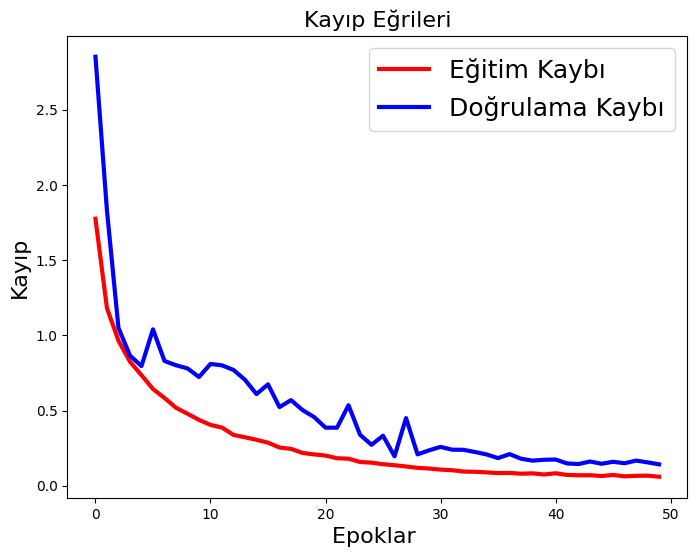

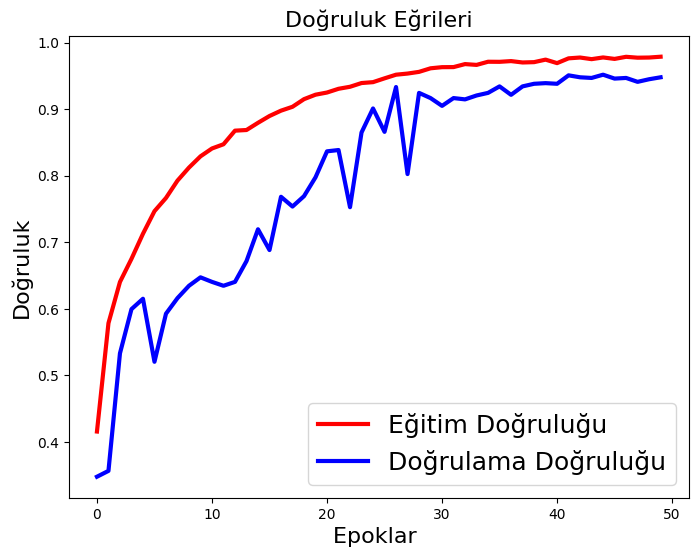

In [10]:
# Kayıp Eğrilerini Çiz
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Eğitim Kaybı', 'Doğrulama Kaybı'],fontsize=18)
plt.xlabel('Epoklar ',fontsize=16)
plt.ylabel('Kayıp',fontsize=16)
plt.title('Kayıp Eğrileri',fontsize=16)
plt.show()

# Doğruluk Eğrilerini Çiz
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Eğitim Doğruluğu', 'Doğrulama Doğruluğu'],fontsize=18)
plt.xlabel('Epoklar ',fontsize=16)
plt.ylabel('Doğruluk',fontsize=16)
plt.title('Doğruluk Eğrileri',fontsize=16)
plt.show()

# Adım 9: Modelin Değerlendirilmesi


--- Modelin Son Değerlendirilmesi ---
80/80 [==============================] - 1s 10ms/step - loss: 0.1873 - accuracy: 0.9398

Test Seti Kaybı: 0.1873
Test Seti Doğruluğu: 93.98%

Sınıflandırma Raporu:
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.87      0.93       344
 Moderate_Demented       1.00      0.93      0.97        30
      Non_Demented       0.96      0.94      0.95      1268
Very_Mild_Demented       0.89      0.96      0.93       918

          accuracy                           0.94      2560
         macro avg       0.96      0.93      0.94      2560
      weighted avg       0.94      0.94      0.94      2560


Test Seti Karışıklık Matrisi:


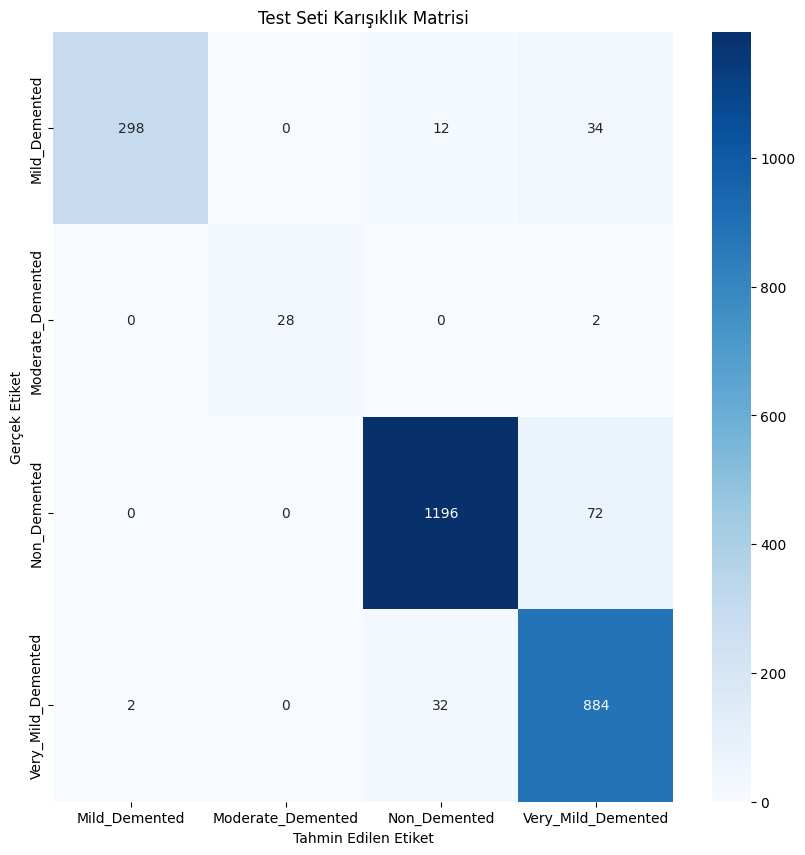

In [18]:
def predict_in_batches(model, data, batch_size=BATCH_SIZE):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_pred = model.predict(batch, verbose=0)
        predictions.extend(batch_pred)
    return np.array(predictions)

# En iyi model ağırlıklarını yükle
baseline_cnn .load_weights(str(model_path)) 

print("\n--- Modelin Son Değerlendirilmesi ---")

# Test seti üzerinde doğruluk ve kayıp değerlerini hesapla
loss, acc = baseline_cnn .evaluate(x_test_raw, y_test_cat, verbose=1)
print(f"\nTest Seti Kaybı: {loss:.4f}")
print(f"Test Seti Doğruluğu: {acc*100:.2f}%")

# Tahminleri toplu halde al
predicted_probs = predict_in_batches(baseline_cnn , x_test_raw)
predicted_classes = np.argmax(predicted_probs, axis=1)

print("\nSınıflandırma Raporu:")
print(classification_report(y_test_raw, predicted_classes, target_names=LABELS))

print("\nTest Seti Karışıklık Matrisi:")
final_cm = confusion_matrix(y_test_raw, predicted_classes)

# Isı haritası ile karışıklık matrisini çiz
plt.figure(figsize=(10, 10))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title('Test Seti Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

In [19]:
loss, acc = baseline_cnn.evaluate(x_test_raw, y_test_cat, verbose=1)

80/80 [==============================] - 1s 13ms/step - loss: 0.1873 - accuracy: 0.9398
